In [476]:
import dask.dataframe as dd 
from PIL import Image
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (20,15)

In [3]:
dtypes = {"paciente_endereco_coIbgeMunicipio": "object",
         "paciente_endereco_coPais": "object",
         "vacina_grupoAtendimento_codigo": "object",
         "paciente_idade": "object",
         "paciente_racaCor_codigo": "object",
         "vacina_categoria_codigo": "object",
         "paciente_endereco_cep": "object"}

In [4]:
df = dd.read_csv("E:/data-covid/dados-covid-fortaleza.csv", dtype=dtypes)
df = df.compute()

In [5]:
df.shape

(11211662, 33)

In [617]:
df.columns

Index(['Unnamed: 0', 'document_id', 'paciente_id', 'paciente_idade',
       'paciente_dataNascimento', 'paciente_enumSexoBiologico',
       'paciente_racaCor_codigo', 'paciente_racaCor_valor',
       'paciente_endereco_coIbgeMunicipio', 'paciente_endereco_coPais',
       'paciente_endereco_nmMunicipio', 'paciente_endereco_nmPais',
       'paciente_endereco_uf', 'paciente_endereco_cep',
       'paciente_nacionalidade_enumNacionalidade', 'estabelecimento_valor',
       'estabelecimento_razaoSocial', 'estalecimento_noFantasia',
       'estabelecimento_municipio_codigo', 'estabelecimento_municipio_nome',
       'estabelecimento_uf', 'vacina_grupoAtendimento_codigo',
       'vacina_grupoAtendimento_nome', 'vacina_categoria_codigo',
       'vacina_categoria_nome', 'vacina_lote', 'vacina_fabricante_nome',
       'vacina_fabricante_referencia', 'vacina_dataAplicacao',
       'vacina_descricao_dose', 'vacina_codigo', 'vacina_nome',
       'sistema_origem'],
      dtype='object')

In [6]:
df.head(1)

,Unnamed: 0,document_id,paciente_id,paciente_idade,paciente_dataNascimento,paciente_enumSexoBiologico,paciente_racaCor_codigo,paciente_racaCor_valor,paciente_endereco_coIbgeMunicipio,paciente_endereco_coPais,...,vacina_categoria_codigo,vacina_categoria_nome,vacina_lote,vacina_fabricante_nome,vacina_fabricante_referencia,vacina_dataAplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,sistema_origem
0,0,8275cd0b-b3f0-4ec3-bf65-92e1c4038ccc-i0b0,b65f5c388de9c1b4cfce9c85985f5094e001e18bbbff9a...,73,1948-02-21,F,03,PARDA,230440,10,...,2,Faixa Etária,210060,SINOVAC/BUTANTAN,BUTANTAN - FUNDACAO BUTANTAN/61189445000156,2021-03-25,1ª Dose,86,COVID-19 SINOVAC/BUTANTAN - CORONAVAC,Fastmedic - FastSaude


In [333]:
df.vacina_descricao_dose.unique()

array(['1ª Dose', '2ª Dose', 'Reforço', 'Dose Adicional', 'Única',
       '4ª Dose', '3ª Dose', '1º Reforço', '5ª Dose', '2º Reforço'],
      dtype=object)

In [395]:
vac_ignore = ['1ª Dose', '2ª Dose', 'Única']
drop_columns = ["Unnamed: 0", "document_id"]
new_df = df[~df.vacina_descricao_dose.isin(vac_ignore)][[i for i in df.columns if i not in drop_columns]]

In [396]:
new_df.vacina_descricao_dose.unique()

array(['Reforço', 'Dose Adicional', '4ª Dose', '3ª Dose', '1º Reforço',
       '5ª Dose', '2º Reforço'], dtype=object)

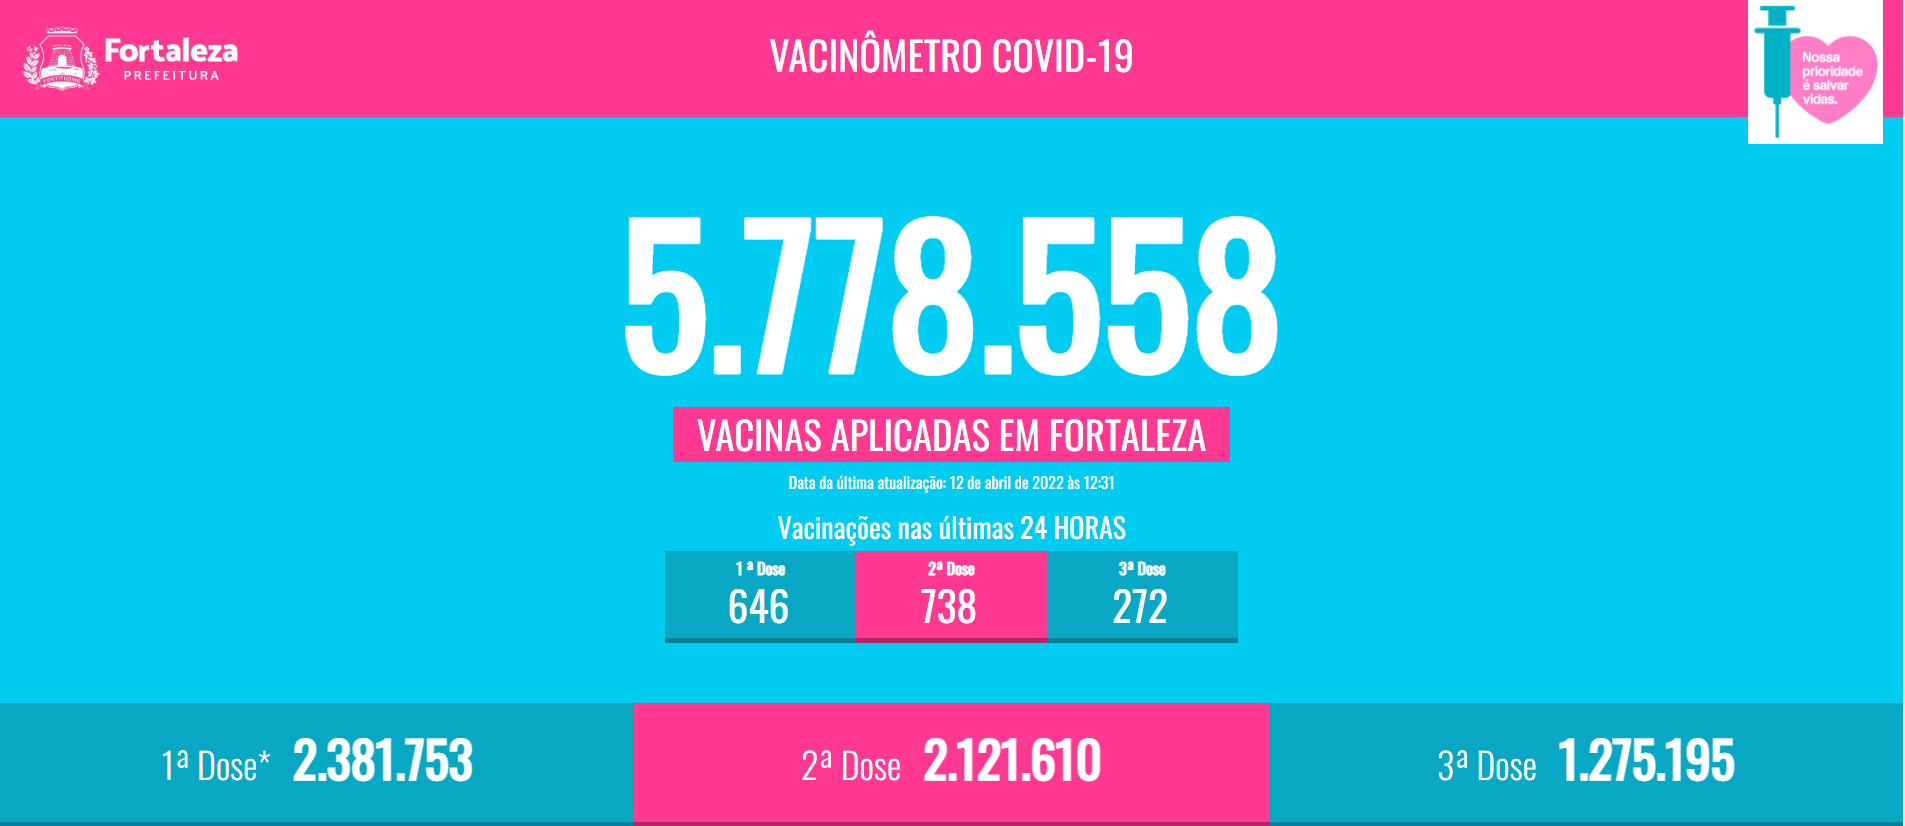

In [397]:
Image.open("vacinometro.png")

In [398]:
new_df.shape

(1254933, 31)

In [399]:
new_df.vacina_dataAplicacao = pd.to_datetime(new_df.vacina_dataAplicacao)

In [400]:
new_df_groupby = new_df[["paciente_id", "vacina_dataAplicacao"]].groupby("vacina_dataAplicacao").size().reset_index().rename(columns={0: "qt_vacinacao"})

In [401]:
new_df_groupby

,vacina_dataAplicacao,qt_vacinacao
0,2020-01-14,1
1,2021-01-20,1
2,2021-03-21,1
3,2021-04-28,1
4,2021-05-03,1
...,...,...
231,2022-04-04,1907
232,2022-04-05,1621
233,2022-04-06,238
234,2022-04-07,8


In [402]:
import plotly.express as px

In [403]:
fig = px.line(new_df_groupby[["qt_vacinacao", "vacina_dataAplicacao"]], 
              x="vacina_dataAplicacao", 
              y="qt_vacinacao", 
              title='Número de vacinações 3ª dose do inicio até dia 06/04/2022')
fig.show()

In [404]:
def convert_dias_semana(dia_semana):
    case = {
       'Monday': 'Segunda-Feira', 
       'Sunday': 'Domingo', 
       'Saturday': 'Sabado', 
       'Friday': 'Sexta-Feira', 
       'Wednesday': 'Quarta-Feira', 
       'Tuesday': 'Terça-Feira',
       'Thursday': 'Quinta-Feira'
    }
    
    return case.get(dia_semana)


def convert_dias_to_int(dia_semana):
    case = {
        'Domingo': 1, 
        'Segunda-Feira':2 , 
        'Terça-Feira': 3,
        'Quarta-Feira': 4, 
        'Quinta-Feira': 5,
        'Sexta-Feira': 6, 
        'Sabado': 7
    }
    
    return case.get(dia_semana)



new_df_groupby["dia_da_semana"] = new_df_groupby.vacina_dataAplicacao.dt.day_name().apply(lambda x: convert_dias_semana(x))
new_df_groupby["index_dia_da_semana"] = new_df_groupby.vacina_dataAplicacao.dt.day_name().apply(lambda x: convert_dias_to_int(convert_dias_semana(x)))
new_df_groupby["dia_do_mes"] = new_df_groupby.vacina_dataAplicacao.dt.day
new_df_groupby["ano_mes"] = new_df_groupby.vacina_dataAplicacao.dt.strftime("%Y-%m")
new_df_groupby["ano"] = new_df_groupby.vacina_dataAplicacao.dt.year

In [405]:
new_df_groupby

,vacina_dataAplicacao,qt_vacinacao,dia_da_semana,index_dia_da_semana,dia_do_mes,ano_mes,ano
0,2020-01-14,1,Terça-Feira,3,14,2020-01,2020
1,2021-01-20,1,Quarta-Feira,4,20,2021-01,2021
2,2021-03-21,1,Domingo,1,21,2021-03,2021
3,2021-04-28,1,Quarta-Feira,4,28,2021-04,2021
4,2021-05-03,1,Segunda-Feira,2,3,2021-05,2021
...,...,...,...,...,...,...,...
231,2022-04-04,1907,Segunda-Feira,2,4,2022-04,2022
232,2022-04-05,1621,Terça-Feira,3,5,2022-04,2022
233,2022-04-06,238,Quarta-Feira,4,6,2022-04,2022
234,2022-04-07,8,Quinta-Feira,5,7,2022-04,2022


In [406]:
new_df_groupby_dia_da_semana = new_df_groupby[["qt_vacinacao", "dia_da_semana", "index_dia_da_semana"]].groupby(["dia_da_semana", "index_dia_da_semana"]).sum().reset_index().sort_values("index_dia_da_semana")


fig = px.line(new_df_groupby_dia_da_semana, 
              x="dia_da_semana", 
              y="qt_vacinacao", 
              title='Número de vacinações ao longo da semana')
fig.show()

In [407]:
new_df_groupby_dia_do_mes = new_df_groupby[["qt_vacinacao", "dia_do_mes"]].groupby("dia_do_mes").sum().reset_index().sort_values("dia_do_mes")


fig = px.line(new_df_groupby_dia_do_mes, 
              x="dia_do_mes", 
              y="qt_vacinacao", 
              title='Número de vacinações ao longo do mês')
fig.show()

In [408]:
new_df_groupby_mes= new_df_groupby[["qt_vacinacao", "ano_mes"]].groupby("ano_mes").sum().reset_index().sort_values("ano_mes")


fig = px.line(new_df_groupby_mes, 
              x="ano_mes", 
              y="qt_vacinacao", 
              title='Número de vacinações ao longo do mês')
fig.show()

#### Comparando este gráfico com o primeiro gráfico onde lá a gente plota a quantidade de vacinação dia a dia e aqui mês a mês, podemos notar que esse gráfico tá mais suave, pois retiramos a variação diária.

In [559]:
columns_select = ["ano_mes","qt_vacinacao"]
filter_date = ((new_df_groupby.ano >= 2021) & (new_df_groupby.ano <= new_df_groupby.ano.max()))
new_df_train = new_df_groupby[filter_date][columns_select].groupby("ano_mes").sum().reset_index().rename(columns={0: "ano_mes"}).set_index("ano_mes")

In [560]:
new_df_train

,qt_vacinacao
ano_mes,
2021-01,1
2021-03,1
2021-04,1
2021-05,3
2021-06,3
2021-07,5
2021-08,15
2021-09,15606
2021-10,102247


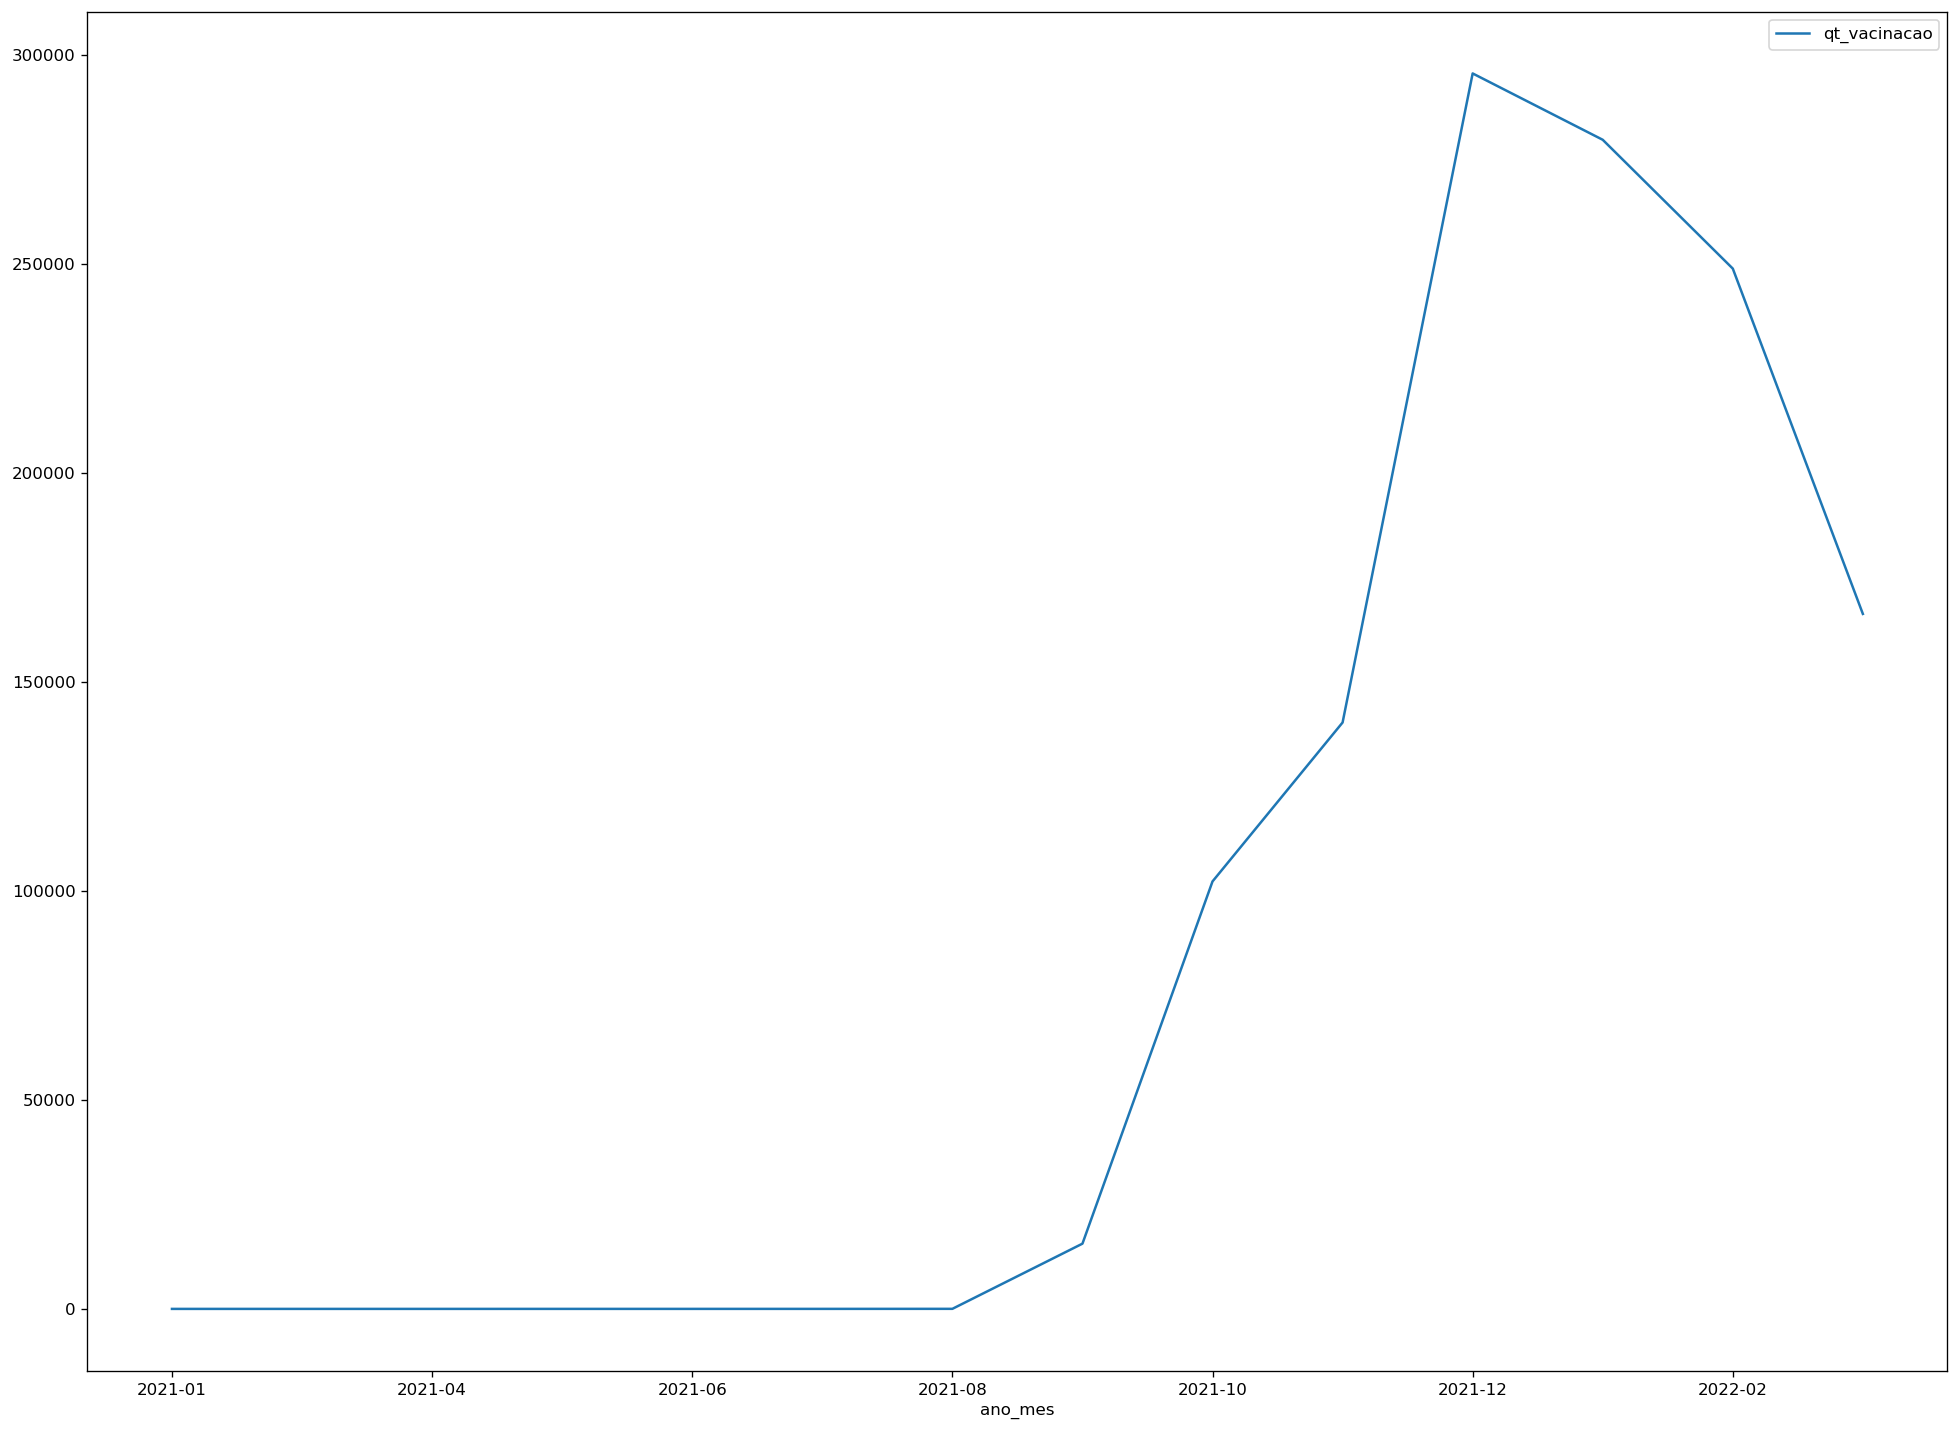

In [561]:
new_df_train.iloc[:-1].plot();

In [562]:
from statsmodels.tsa.stattools import adfuller

In [563]:
def adfuller_test(g_celsius):
    result=adfuller(g_celsius)
    labels = ['ADF Teste Estatistico','p-value','Num Lags','Num Observações']
    for value,label in zip(result,labels):
        print(label+' : '+str(round(value, 2) ))

    if result[1] <= 0.05:
        print("forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados são estacionários")
    else:
        print("evidência fraca contra a hipótese nula, indicando que é não estacionária")


adfuller_test(new_df_train)

ADF Teste Estatistico : 2.07
p-value : 1.0
Num Lags : 4
Num Observações : 10
evidência fraca contra a hipótese nula, indicando que é não estacionária


### Aplicando diferenciações na série e verificando com quantas diferenciações a série torna-se estacionária

In [564]:
from pmdarima.arima.utils import ndiffs

print("ADF test =", ndiffs(new_df_train, test='adf'))
# KPSS test
print("KPSS test =", ndiffs(new_df_train, test='kpss')) 
# PP test:
print("PP test =", ndiffs(new_df_train, test='pp'))  

ADF test = 2
KPSS test = 0
PP test = 2


Melhor parametro para o termo <b>I (d)</b>

    Nosso d é 2, 0 ou 1

### Encontrando o termo MA (q)

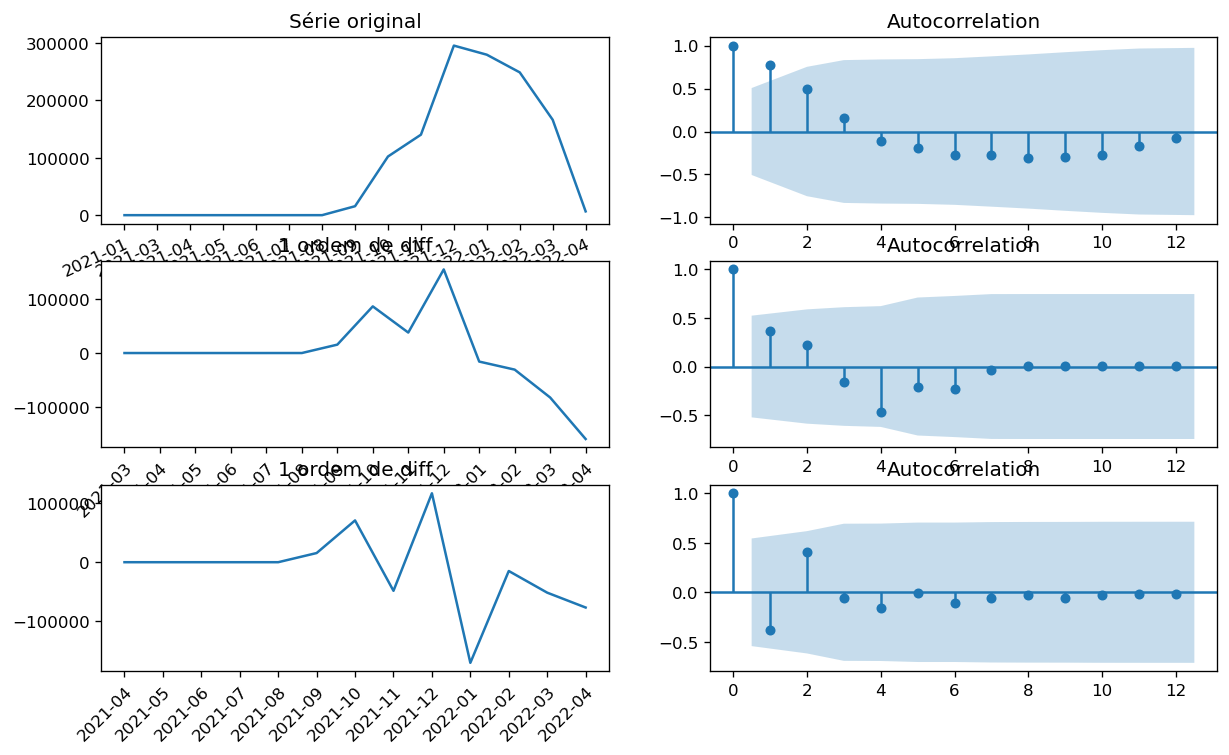

In [565]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(new_df_train); 
axes[0, 0].set_title('Série original')
axes[0, 0].set_xticklabels([i for i in new_df_train.index] ,rotation=25, ha='right', rotation_mode='anchor')
plot_acf(new_df_train, ax=axes[0, 1])


order_diff_1 = new_df_train.diff().dropna()
axes[1, 0].plot(order_diff_1); 
axes[1, 0].set_title('1 ordem de diff')
axes[1, 0].set_xticklabels([i for i in order_diff_1.index] ,rotation=45, ha='right', rotation_mode='anchor')
plot_acf(order_diff_1, ax=axes[1, 1])

order_diff_2 = new_df_train.diff().dropna().diff().dropna()
axes[2, 0].plot(order_diff_2); 
axes[2, 0].set_title('1 ordem de diff')
axes[2, 0].set_xticklabels([i for i in order_diff_2.index] ,rotation=45, ha='right', rotation_mode='anchor')
plot_acf(order_diff_2, ax=axes[2, 1])

plt.show()

<b>NOTAS:</b>

    Na segunda linha de gráficos, podemos observar que, a unica defasagem é no lag 0, portanto nosso termo MA (q) = 0

## Encontrando o termo AR (p)

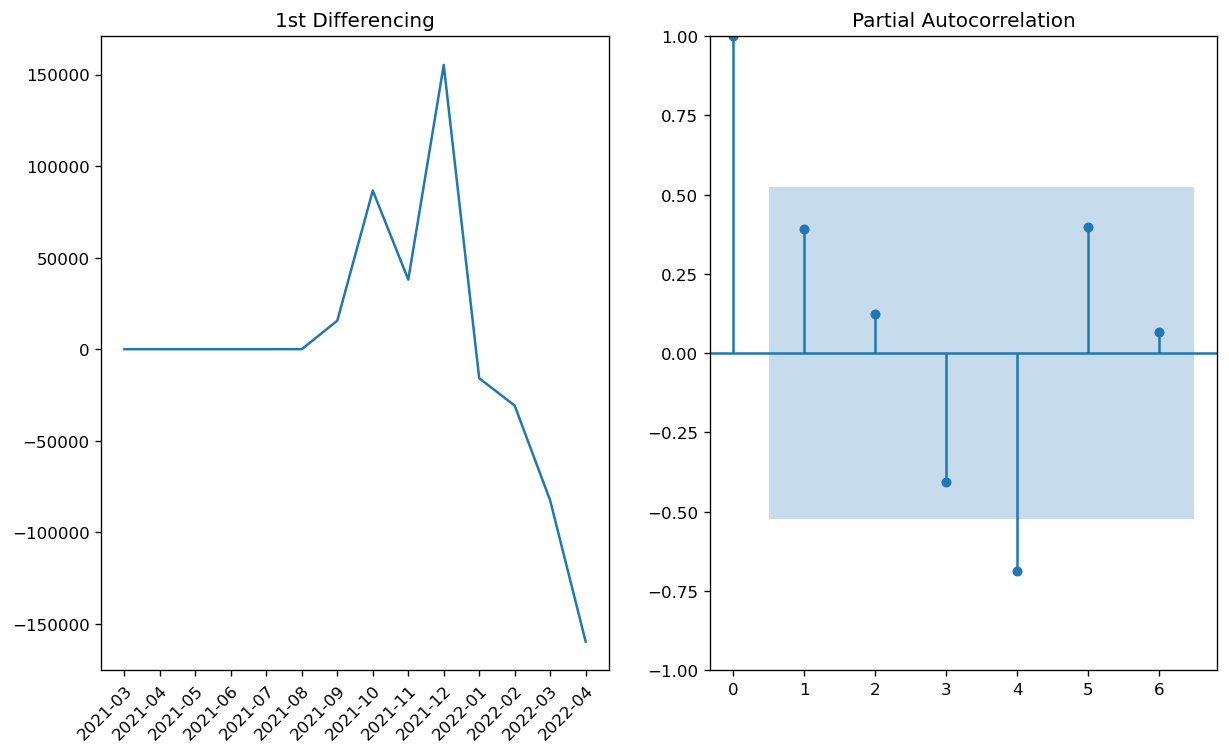

In [566]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(order_diff_1); 
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(-1,1))
plot_pacf(order_diff_1, ax=axes[1], lags=6)
axes[0].set_xticklabels([i for i in order_diff_1.index] ,rotation=45, ha='right', rotation_mode='anchor')
plt.show()

<b>NOTAS:</b>
    
    Como a única defasagem significativa é no lag 0. Por conta disso o  AR (p)=0

In [567]:
order_diff_1

,qt_vacinacao
ano_mes,
2021-03,0.000
2021-04,0.000
2021-05,2.000
2021-06,0.000
2021-07,2.000
2021-08,10.000
2021-09,15591.000
2021-10,86641.000
2021-11,38014.000


In [568]:
size = 0.1
train_size = int(new_df_train.iloc[:-1].shape[0] * (1 - size))

train = new_df_train.sort_index().iloc[0: train_size]
test  = new_df_train.sort_index().iloc[train_size:-1]

In [569]:
train

,qt_vacinacao
ano_mes,
2021-01,1
2021-03,1
2021-04,1
2021-05,3
2021-06,3
2021-07,5
2021-08,15
2021-09,15606
2021-10,102247


In [570]:
test

,qt_vacinacao
ano_mes,
2022-02,248825
2022-03,166232


In [616]:
from statsmodels.tsa.arima_model import ARIMA
import warnings 
warnings.filterwarnings('ignore')


arima = ARIMA(train, order=(1, 1, 0))


arima_results = arima.fit(disp=0)
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.qt_vacinacao_cum   No. Observations:                   10
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -124.916
Method:                       css-mle   S.D. of innovations          60009.091
Date:                Wed, 13 Apr 2022   AIC                            255.832
Time:                        22:31:46   BIC                            256.740
Sample:                    05-01-2021   HQIC                           254.836
                         - 02-01-2022                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      1.04e+05   9.61e+04      1.083      0.279   -8.43e+04    2.92e+05
ar.L1.D.qt_vacinacao_cum     0.8692      0.134      6.510      0.000       0.607       1.131
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1505           +0.0000j            1.1505            0.0000
-----------------------------------------------------------------------------
"""

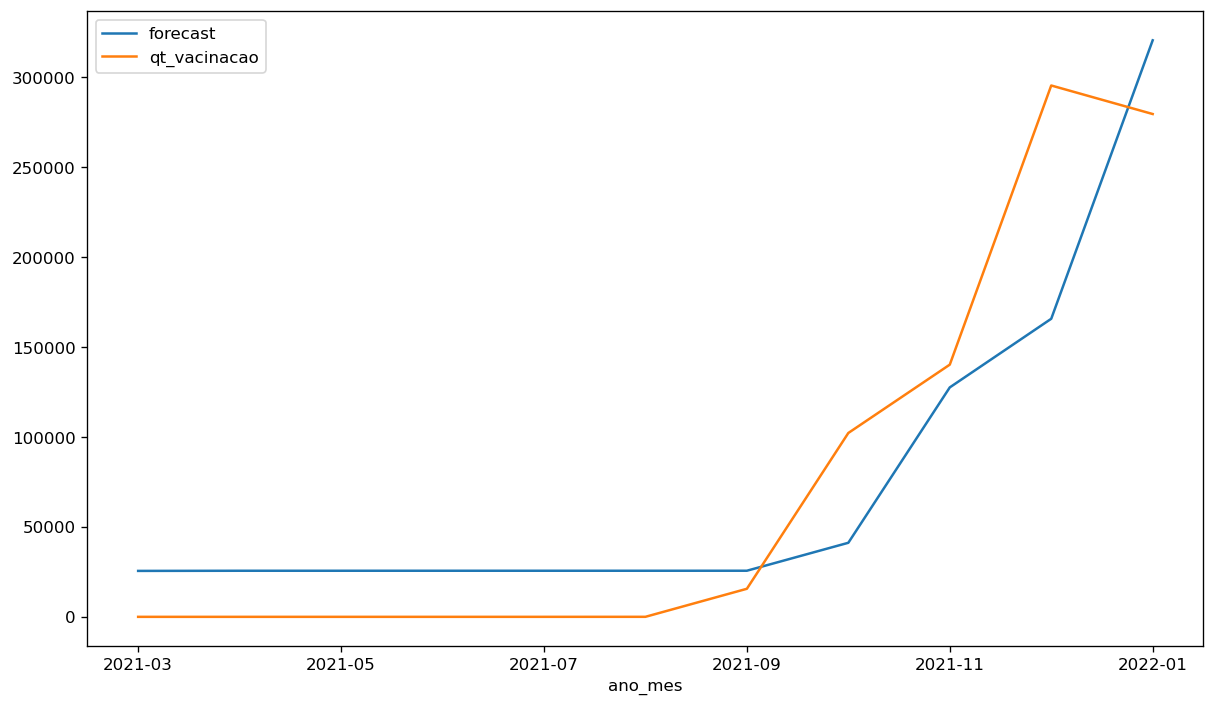

In [572]:
arima_results.plot_predict(dynamic=False);

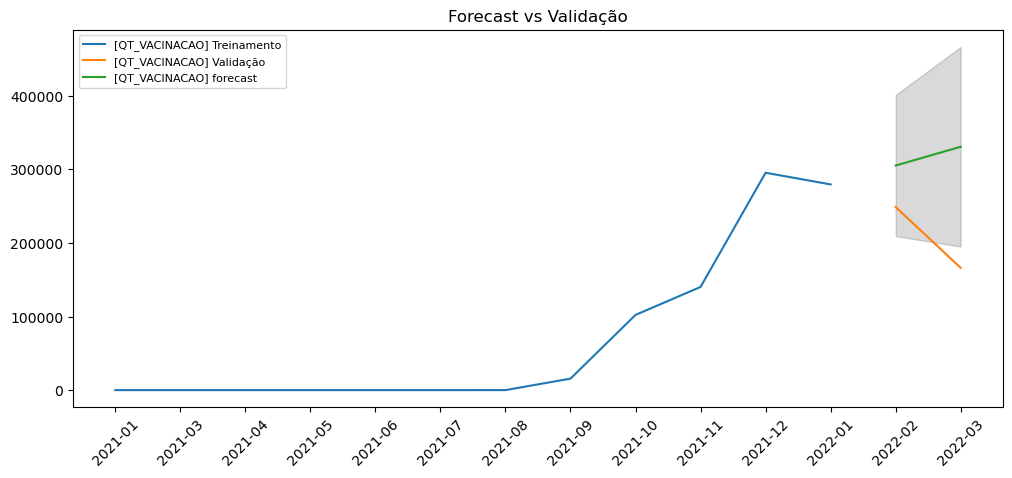

In [573]:
sample = 2
test_ = test.iloc[0:sample]
train_ = train
fc, se, conf = arima_results.forecast(sample, alpha=0.05)  # 95% conf


fc_series = pd.Series(fc, index=test_.index)
lower_series = pd.Series(conf[:, 0], index=test_.index)
upper_series = pd.Series(conf[:, 1], index=test_.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_, label='[QT_VACINACAO] Treinamento')
plt.plot(test_, label='[QT_VACINACAO] Validação')
plt.plot(fc_series, label='[QT_VACINACAO] forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Validação')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=45)
plt.show()

In [574]:
sample_size = 2000
fc, se, conf = arima_results.forecast(test.iloc[0:sample_size].shape[0], alpha=0.05) 

In [575]:
y_pred = fc 
y_true = test.iloc[0:sample_size].values.flatten()

In [576]:
MAE = np.mean(abs(y_true - y_pred))
RMSE = np.sqrt(((y_true - y_pred) ** 2).mean())

df_stats = pd.DataFrame()
dict_stats = {"MODELO": "ARIMA 1", "MAE": MAE, "RMSE": RMSE}
df_stats = df_stats.append([dict_stats])

print("Erro médio Abs=",MAE)
print("Erro quadratico médio=", RMSE)

Erro médio Abs= 110564.55335545604
Erro quadratico médio= 123077.88221697343


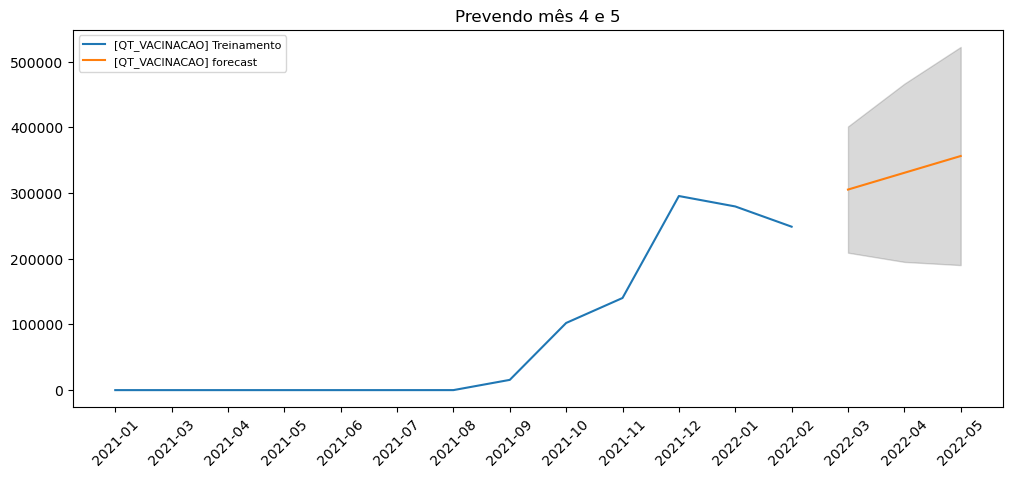

2022-03   305318.816
2022-04   330867.291
2022-05   356416.187
dtype: float64

In [587]:
sample = 3

train_ = pd.concat([train, test.iloc[:-1]])
fc, se, conf = arima_results.forecast(sample, alpha=0.05)  # 95% conf

index =  pd.date_range(test.index.min(), '2022-06', freq="M").to_period("M")

index = [str(i) for i in index if str(i) != test.index.min()]

fc_series = pd.Series(fc, index=index)
lower_series = pd.Series(conf[:, 0], index=index)
upper_series = pd.Series(conf[:, 1], index=index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_, label='[QT_VACINACAO] Treinamento')
plt.plot(fc_series, label='[QT_VACINACAO] forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Prevendo mês 4 e 5')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=45)
plt.show()

fc_series

### Modelo 2 Arima, com uma outra configuração

In [588]:
size = 0.05
train_size = int(new_df_train.iloc[2:].iloc[:-1].shape[0] * (1 - size))

train = new_df_train.iloc[2:].sort_index().iloc[0: train_size]
test  = new_df_train.iloc[2:].sort_index().iloc[train_size:]

In [589]:
from statsmodels.tsa.arima_model import ARIMA
import warnings 
warnings.filterwarnings('ignore')



arima = ARIMA(train, order=(2, 2, 0))


arima_results = arima.fit(disp=0)
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D2.qt_vacinacao   No. Observations:                    9
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -112.612
Method:                       css-mle   S.D. of innovations          64890.154
Date:                Wed, 13 Apr 2022   AIC                            233.224
Time:                        22:27:16   BIC                            234.013
Sample:                    06-01-2021   HQIC                           231.522
                         - 02-01-2022                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -4369.2983   1.91e+04     -0.229      0.819   -4.18e+04    3.31e+04
ar.L1.D2.qt_vacinacao    -0.4151      0.433     -0.959      0.338      -1.263       0.433
ar.L2.D2.qt_vacinacao     0.0737      0.591      0.125      0.901      -1.086       1.233
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.8205           +0.0000j            1.8205            0.5000
AR.2            7.4522           +0.0000j            7.4522            0.0000
-----------------------------------------------------------------------------
"""

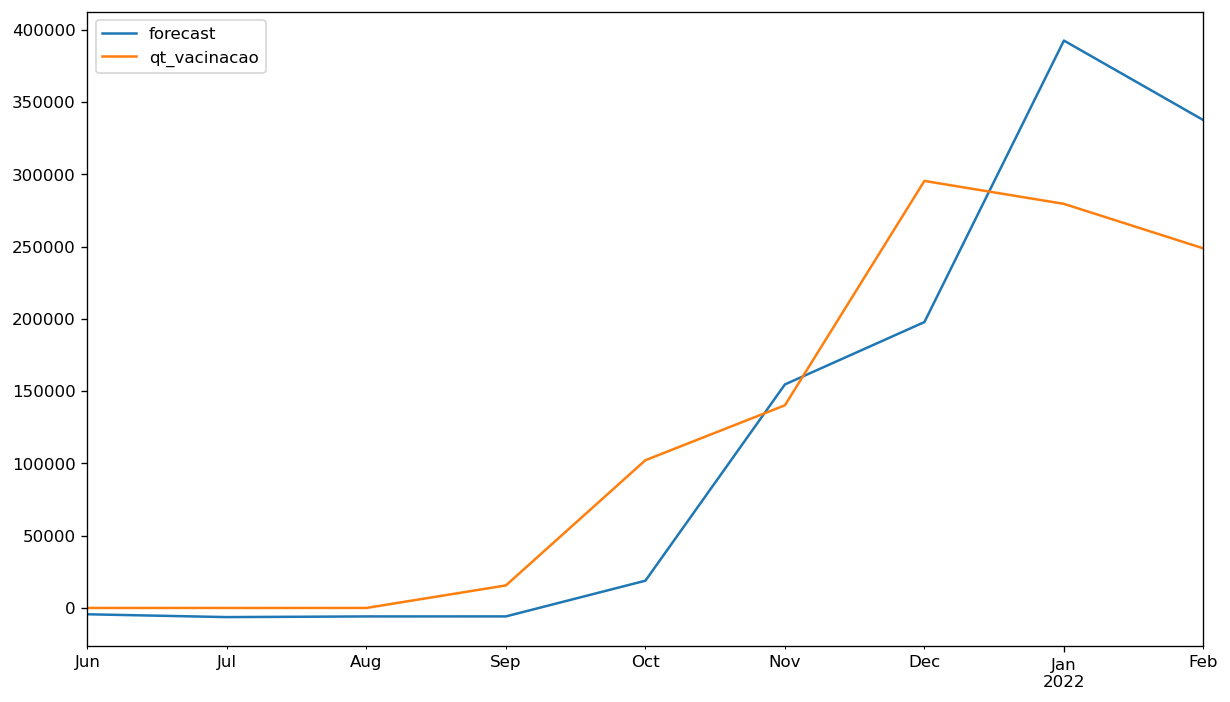

In [590]:
arima_results.plot_predict(dynamic=False);

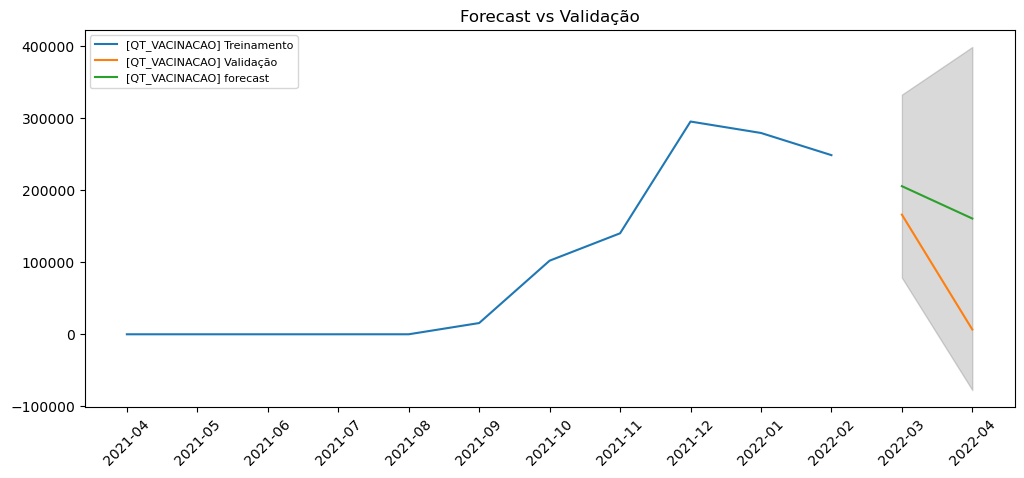

In [591]:
sample = 2
test_ = test.iloc[0:sample]
train_ = train
fc, se, conf = arima_results.forecast(sample, alpha=0.05)  # 95% conf


fc_series = pd.Series(fc, index=test_.index)
lower_series = pd.Series(conf[:, 0], index=test_.index)
upper_series = pd.Series(conf[:, 1], index=test_.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_, label='[QT_VACINACAO] Treinamento')
plt.plot(test_, label='[QT_VACINACAO] Validação')
plt.plot(fc_series, label='[QT_VACINACAO] forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Validação')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=45)
plt.show()

NOTAS: 
    
    No gráfico acima, podemos observar que o modelo está prevendo uma leve queda no número de vacinações para este mês 04/2022.

In [592]:
sample_size = 2000
fc, se, conf = arima_results.forecast(test.iloc[0:sample_size].shape[0], alpha=0.05) 

In [593]:
y_pred = fc 
y_true = test.iloc[0:sample_size].values.flatten()

In [594]:
MAE = np.mean(abs(y_true - y_pred))
RMSE = np.sqrt(((y_true - y_pred) ** 2).mean())

df_stats = pd.DataFrame()
dict_stats = {"MODELO": "ARIMA 1", "MAE": MAE, "RMSE": RMSE}
df_stats = df_stats.append([dict_stats])

print("Erro médio Abs=",MAE)
print("Erro quadratico médio=", RMSE)

Erro médio Abs= 96856.01932413151
Erro quadratico médio= 112559.72465843661


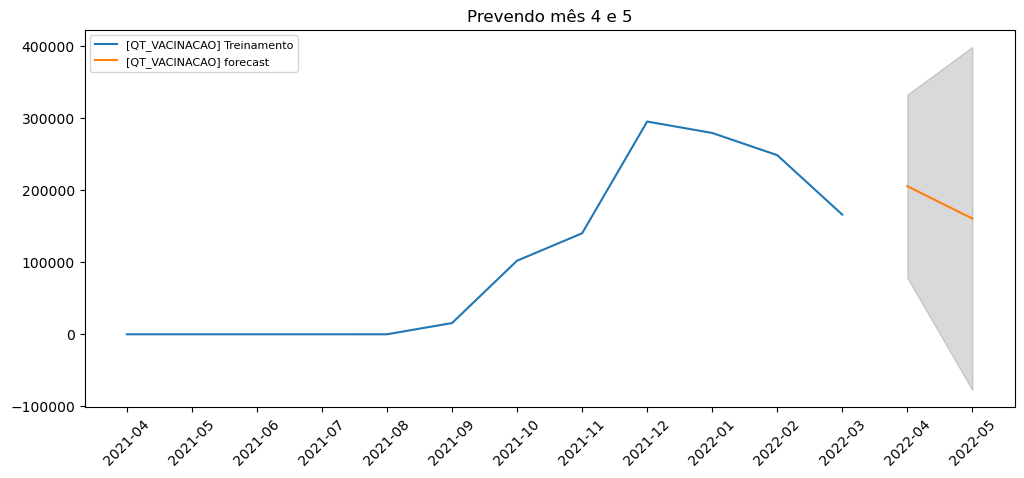

2022-04   205741.676
2022-05   160789.363
dtype: float64

In [595]:
sample = 2

train_ = pd.concat([train, test.iloc[:-1]])
fc, se, conf = arima_results.forecast(sample, alpha=0.05)  # 95% conf

index =  pd.date_range(test.index.min(), '2022-06', freq="M").to_period("M")

index = [str(i) for i in index if str(i) != test.index.min()]

fc_series = pd.Series(fc, index=index)
lower_series = pd.Series(conf[:, 0], index=index)
upper_series = pd.Series(conf[:, 1], index=index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_, label='[QT_VACINACAO] Treinamento')
plt.plot(fc_series, label='[QT_VACINACAO] forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Prevendo mês 4 e 5')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=45)
plt.show()

fc_series

### Prevendo a data de conclusão de vacinação da 3ª dose em Fortaleza

In [596]:
min_date = new_df_train.reset_index().ano_mes.min() 

new_df_train["qt_vacinacao_cum"] = new_df_train.cumsum()

In [597]:
new_df_train

,qt_vacinacao,qt_vacinacao_cum
ano_mes,,
2021-01,1,1
2021-03,1,2
2021-04,1,3
2021-05,3,6
2021-06,3,9
2021-07,5,14
2021-08,15,29
2021-09,15606,15635
2021-10,102247,117882


In [598]:
new_df_train_ = new_df_train.drop("qt_vacinacao", axis=1)

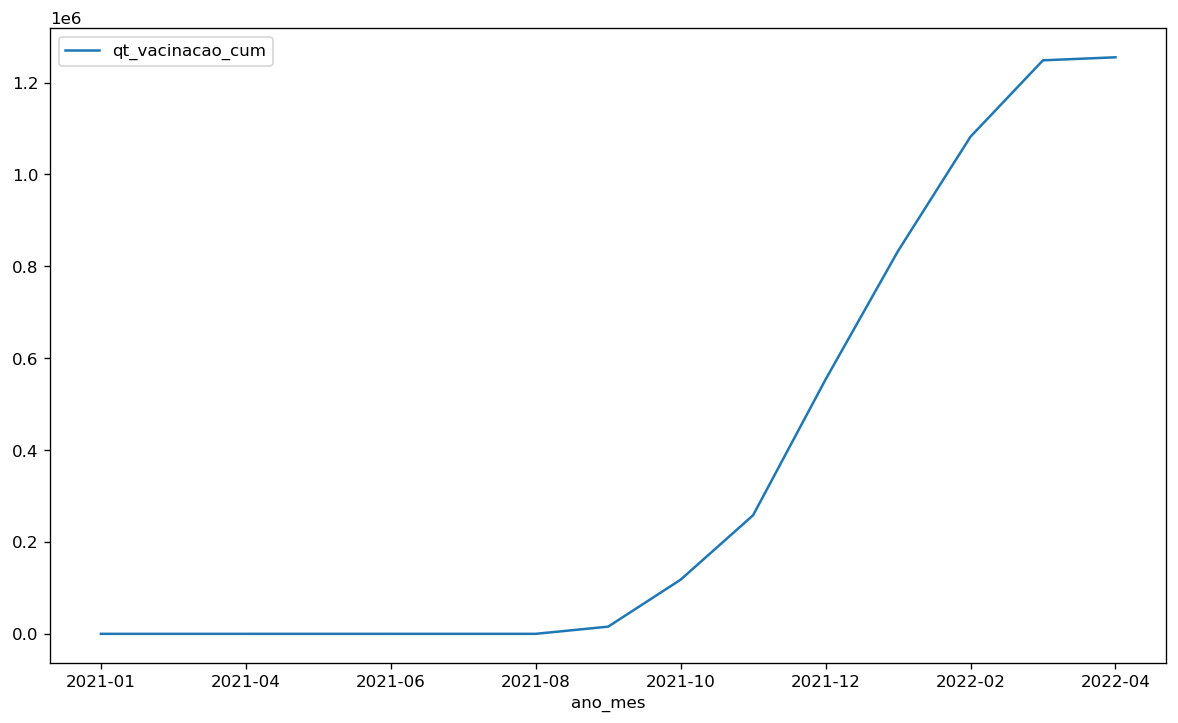

In [599]:
new_df_train_.plot();

In [600]:
size = 0.05
train_size = int(new_df_train_.iloc[2:].iloc[:-1].shape[0] * (1 - size))

train = new_df_train_.iloc[2:].sort_index().iloc[0: train_size]
test  = new_df_train_.iloc[2:].sort_index().iloc[train_size:]

In [601]:
train

,qt_vacinacao_cum
ano_mes,
2021-04,3
2021-05,6
2021-06,9
2021-07,14
2021-08,29
2021-09,15635
2021-10,117882
2021-11,258143
2021-12,553650


In [602]:
test

,qt_vacinacao_cum
ano_mes,
2022-03,1248345
2022-04,1254932


In [603]:
from statsmodels.tsa.arima_model import ARIMA
import warnings 
warnings.filterwarnings('ignore')



arima = ARIMA(train, order=(2, 2, 0))


arima_results = arima.fit(disp=0)
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                              
===============================================================================
Dep. Variable:     D2.qt_vacinacao_cum   No. Observations:                    9
Model:                  ARIMA(2, 2, 0)   Log Likelihood                -111.063
Method:                        css-mle   S.D. of innovations          55337.584
Date:                 Wed, 13 Apr 2022   AIC                            230.127
Time:                         22:27:19   BIC                            230.916
Sample:                     06-01-2021   HQIC                           228.424
                          - 02-01-2022                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2.854e+04   1.91e+04      1.490      0.136   -8995.146    6.61e+04
ar.L1.D2.qt_vacinacao_cum    -0.0057      0.354     -0.016      0.987      -0.700       0.689
ar.L2.D2.qt_vacinacao_cum    -0.0448      0.364     -0.123      0.902      -0.758       0.669
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.0635           -4.7217j            4.7221           -0.2521
AR.2           -0.0635           +4.7217j            4.7221            0.2521
-----------------------------------------------------------------------------
"""

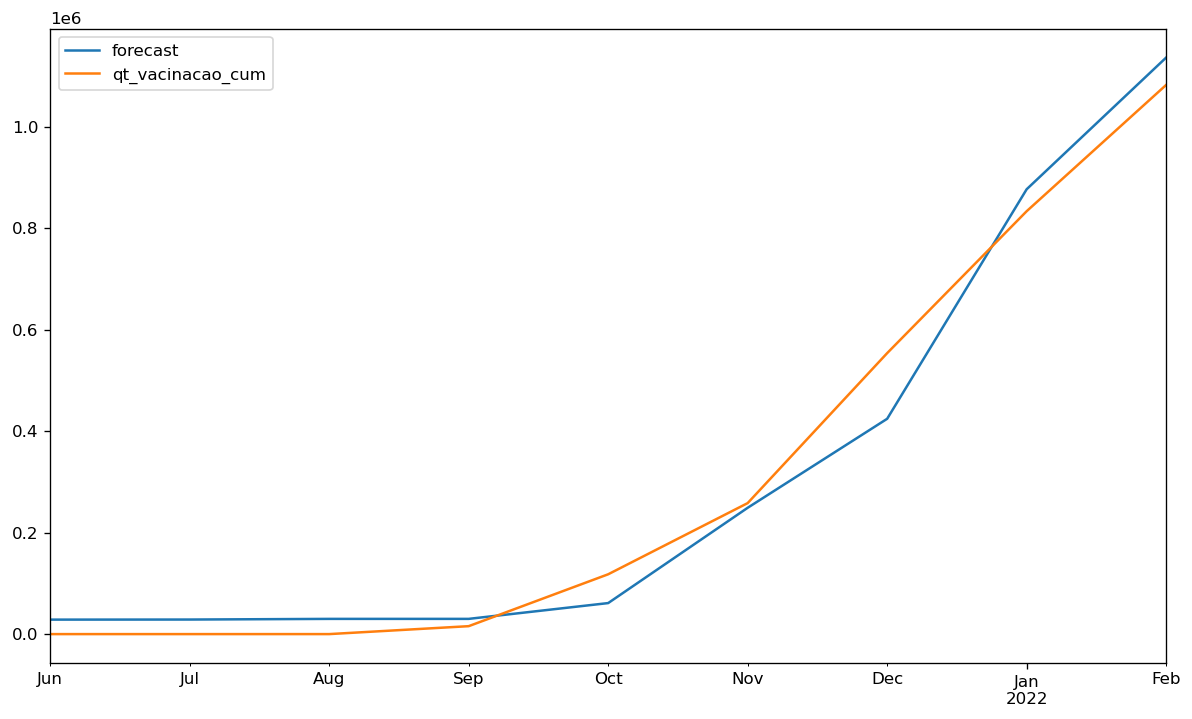

In [604]:
arima_results.plot_predict(dynamic=False);

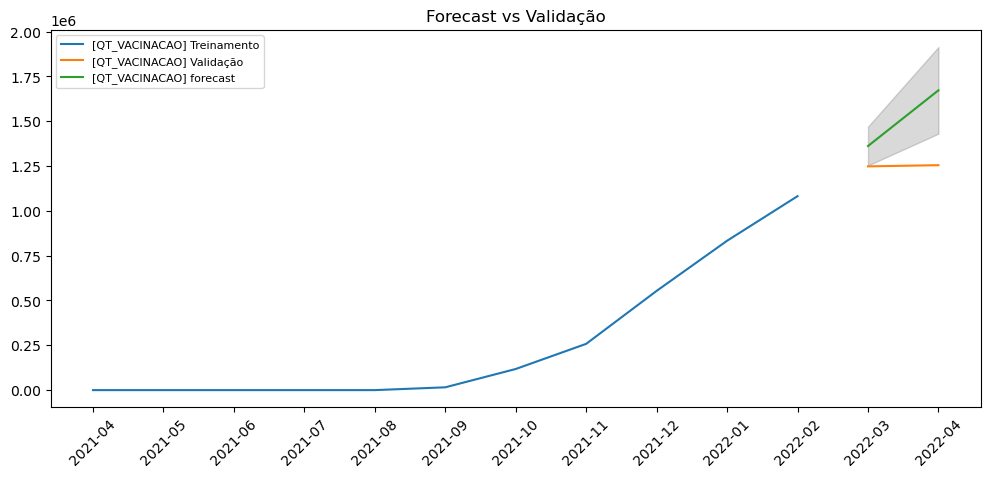

In [605]:
sample = 2
test_ = test.iloc[0:sample]
train_ = train
fc, se, conf = arima_results.forecast(sample, alpha=0.05)  # 95% conf


fc_series = pd.Series(fc, index=test_.index)
lower_series = pd.Series(conf[:, 0], index=test_.index)
upper_series = pd.Series(conf[:, 1], index=test_.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_, label='[QT_VACINACAO] Treinamento')
plt.plot(test_, label='[QT_VACINACAO] Validação')
plt.plot(fc_series, label='[QT_VACINACAO] forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Validação')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=45)
plt.show()

In [606]:
y_pred = fc 
y_true = test.iloc[0:sample_size].values.flatten()

MAE = np.mean(abs(y_true - y_pred))
RMSE = np.sqrt(((y_true - y_pred) ** 2).mean())

df_stats = pd.DataFrame()
dict_stats = {"MODELO": "ARIMA 1", "MAE": MAE, "RMSE": RMSE}
df_stats = df_stats.append([dict_stats])

print("Erro médio Abs=",MAE)
print("Erro quadratico médio=", RMSE)

Erro médio Abs= 265601.2876627173
Erro quadratico médio= 306090.9075062368


### Taxa de vacinação  3ª dose em fortaleza

In [607]:
population_fortaleza = 2703391

In [608]:
print("Taxa de vacinação até o mês de 03/2022 em Fortaleza = ", new_df.shape[0] / population_fortaleza)

Taxa de vacinação até o mês de 03/2022 em Fortaleza =  0.46420699040575336


### Prever o mês de conclusão de vacinação da 3ª dose em fortaleza

In [609]:
rate_vaccination = 0
n_periods = 1
start_date = "2022-03-01"

while rate_vaccination < 100:
    
    date_aux = pd.to_datetime(start_date).to_period('M') + n_periods
    
    
    fc, se, conf = arima_results.forecast(n_periods, alpha=0.05)  # 95% conf
    
    fc = pd.Series(fc).iloc[-1]

    rate_vaccination_aux = fc / population_fortaleza
    
    rate_vaccination = round(rate_vaccination_aux, 2) * 100
    
    print(f"Data estimada: {date_aux}, Taxa de vacinação: {rate_vaccination}%, Num Meses: {n_periods}")
    
    n_periods = n_periods + 1

Data estimada: 2022-04, Taxa de vacinação: 50.0%, Num Meses: 1
Data estimada: 2022-05, Taxa de vacinação: 62.0%, Num Meses: 2
Data estimada: 2022-06, Taxa de vacinação: 74.0%, Num Meses: 3
Data estimada: 2022-07, Taxa de vacinação: 88.0%, Num Meses: 4
Data estimada: 2022-08, Taxa de vacinação: 103.0%, Num Meses: 5
